# Setup

In [1]:
%%capture
!pip install miceforest --no-cache-dir

In [2]:
import gc
import numpy as np
import pandas as pd

gc.enable()
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

import miceforest as mf
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline

SEED = 55

In [3]:
DATA_DIR = '/kaggle/input/playground-series-s3e26'
train = pd.read_csv(f'{DATA_DIR}/train.csv')
test = pd.read_csv(f'{DATA_DIR}/test.csv')
sample_sub = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

original = pd.read_csv('/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv')

# Data overview

In [4]:
train.shape, test.shape, original.shape

((7905, 20), (5271, 19), (418, 20))

In [5]:
train.sample(random_state=SEED)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
3511,3511,1301,Placebo,19270,F,N,N,N,N,0.7,374.0,3.61,24.0,637.0,136.0,135.0,356.0,10.7,2.0,C


In [6]:
original.sample(random_state=SEED)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
245,246,1435,CL,D-penicillamine,12035,F,N,Y,N,N,2.1,387.0,3.77,63.0,1613.0,150.35,33.0,185.0,10.1,4.0


### Target distribution

In [7]:
TARGET = 'Status'

with pd.option_context('display.precision', 3):
    display(pd.concat(
        [
            train[TARGET].value_counts(normalize=True).rename('Train'),
            original[TARGET].value_counts(normalize=True).rename('Original')
        ],
        axis=1
    ))

,Train,Original
Status,,
C,0.628,0.555
D,0.337,0.385
CL,0.035,0.060


### Dropping irrelevant column(s)

In [8]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)
original.drop('ID', axis=1, inplace=True)

original = original[train.columns]

features = list(test.columns)

In [9]:
pd.concat(
    [
        train[features].nunique().rename('Train'),
        test[features].nunique().rename('Test'),
        original[features].nunique().rename('Original')
    ],
    axis=1
).T

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
Train,461,2,391,2,2,2,2,3,111,226,160,171,364,206,154,227,49,4
Test,409,2,363,2,2,2,2,3,108,222,154,164,362,195,155,223,47,4
Original,399,2,344,2,2,2,2,3,98,201,154,158,295,179,146,243,48,4


* No columns with single unique value. No more columns to be dropped for now.
* Original dataset contains only 418 rows, but Train dataset has same range of unique values for numerical columns in ~7900 rows.

In [10]:
# based on number of unique values
cat_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
num_features = [f for f in features if f not in cat_features]

### Missing values

In [11]:
train.isna().sum().sum(), test.isna().sum().sum(), original.isna().sum().sum()

(0, 0, 1033)

In [12]:
original.isna().sum()

N_Days             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
Status             0
dtype: int64

Will need to investigate these in detail if we plan to include original data for training.

Additional information from the original dataset:  
* 424 patients referred to the trial testing the drug D-penicillamine  
* Initial 312 patients took part in the trial and have mostly comprehensive data  
* Remaining 112 patients didn't join the clinical trial but agreed to record basic metrics and undergo survival tracking  
* 6 of these patients were soon untraceable after their diagnosis, leaving data for 106 of these individuals  
* total records: 312 + 106 = 418

In [13]:
trial = original.loc[~original.Drug.isna()].reset_index(drop=True)
non_trial = original.loc[original.Drug.isna()].reset_index(drop=True)

In [14]:
pd.concat(
    [
        trial.isna().sum().rename('Trial'), 
        non_trial.isna().sum().rename('Non-trial')
    ], 
    axis=1
)

,Trial,Non-trial
N_Days,0,0
Drug,0,106
Age,0,0
Sex,0,0
Ascites,0,106
Hepatomegaly,0,106
Spiders,0,106
Edema,0,0
Bilirubin,0,0
Cholesterol,28,106


* The synthetic train data has *Drug* associated with every record, which means all the synthetic patients are participating in the synthetic trial.
* If we plan to include the original data, it would be prudent to include only trial data and deal with a few missing values, instead of including all the data and handling missing values which were not recorded deliberately.  
* (Low-priority) We can still experiment with including non-trial data and handle missing values by imputing manually or leaving them as-is, depending on the model being used.

In [15]:
missing_rows = trial.isna().any(axis=1)

In [16]:
trial[missing_rows]

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
5,2503,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0,D
13,1217,Placebo,20535,M,Y,Y,N,Y,0.8,NaN,2.27,43.0,728.0,71.00,NaN,156.0,11.0,4.0,D
39,4467,D-penicillamine,17046,F,N,N,N,N,1.3,NaN,3.34,105.0,11046.6,104.49,NaN,358.0,11.0,4.0,C
40,1350,D-penicillamine,12285,F,N,Y,N,N,6.8,NaN,3.26,96.0,1215.0,151.90,NaN,226.0,11.7,4.0,D
41,4453,Placebo,12307,F,N,Y,Y,N,2.1,NaN,3.54,122.0,8778.0,56.76,NaN,344.0,11.0,4.0,C
44,4025,Placebo,15265,F,N,N,N,N,0.6,NaN,3.93,19.0,1826.0,71.30,NaN,474.0,10.9,2.0,C
48,708,Placebo,22336,F,N,Y,N,N,0.8,NaN,3.82,58.0,678.0,97.65,NaN,233.0,11.0,4.0,D
52,1000,D-penicillamine,24621,F,N,Y,N,N,2.6,NaN,3.10,94.0,6456.2,56.76,NaN,214.0,11.0,4.0,D
57,4459,D-penicillamine,16279,M,N,N,N,N,0.7,242.0,4.08,73.0,5890.0,56.76,118.0,NaN,10.6,1.0,C
69,3458,D-penicillamine,20600,F,N,N,N,N,0.6,NaN,4.64,20.0,666.0,54.25,NaN,265.0,10.6,2.0,C


* *Copper* and *Platelets* values are missing completely at random. No other value is missing in those (2 + 4) rows.  
* *Tryglicerides* are missing for all rows where *Cholesterol* values are missing. There are 2 rows where *Tryglicerides* are missing but *Cholesterol* values are present. 
* If we use multivariate imputation, we should target *Cholesterol* first.

#### Manual imputation: group-wise median

In [17]:
trial_manual_imp = trial.copy()

for f in ['Copper', 'Platelets', 'Cholesterol', 'Tryglicerides']:
    # fill using median for each target group
    trial_manual_imp[f] = trial_manual_imp[f].fillna(trial_manual_imp.groupby(TARGET)[f].transform('median'))

#### Multivariate imputation: miceforest

In [18]:
trial_mf_imp = trial.copy()
trial_mf_imp[cat_features] = trial_mf_imp[cat_features].astype('category')
trial_mf_imp[TARGET] = trial_mf_imp[TARGET].astype('category')

imputer = mf.ImputationKernel(
    trial_mf_imp,
    mean_match_scheme=mf.mean_match_shap,
    save_all_iterations=False,
    random_state=SEED)

imputer.mice(iterations=5, n_estimators=50)

trial_mf_imp = imputer.complete_data()

In [19]:
trial_manual_imp.isna().sum().sum(), trial_mf_imp.isna().sum().sum()

(0, 0)

### Duplicates

Within train:

In [20]:
train.drop(TARGET, axis=1).duplicated().sum()

0

Between train and test:

In [21]:
pd.concat([train.drop(TARGET, axis=1), test]).duplicated().sum()

0

Between train and original, excluding target:

In [22]:
pd.concat([train.drop(TARGET, axis=1), original.drop(TARGET, axis=1)]).duplicated().sum()

5

Between train and original, including target:

In [23]:
pd.concat([train, original]).duplicated().sum()

0

Same feature values but different target value for 5 rows between train and original datasets:

In [24]:
pd.merge(train, original, how='inner', on=features)

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status_x,Status_y
0,732,D-penicillamine,15056,F,N,Y,N,N,6.1,1712.0,2.83,89.0,3681.0,158.10,139.0,297.0,10.0,3.0,C,CL
1,611,Placebo,26259,M,N,Y,N,S,2.0,420.0,3.26,62.0,3196.0,77.50,91.0,344.0,11.4,3.0,C,D
2,1444,Placebo,19002,F,N,Y,Y,N,5.2,1128.0,3.68,53.0,3228.0,165.85,166.0,421.0,9.9,3.0,C,D
3,901,D-penicillamine,14939,F,N,N,N,N,3.2,339.0,3.18,123.0,3336.0,205.00,84.0,304.0,9.9,4.0,D,CL
4,2055,D-penicillamine,19540,F,N,N,N,N,0.3,233.0,4.08,20.0,622.0,66.65,68.0,358.0,9.9,3.0,C,D


Between test and original:

In [25]:
pd.concat([test, original.drop(TARGET, axis=1)]).duplicated().sum()

4

Must check the predictions for these duplicate rows between test and original datasets.

In [26]:
pd.merge(test, original, how='inner', on=features)

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,1084,Placebo,16941,F,N,Y,N,N,3.5,348.0,3.20,121.0,938.0,120.00,146.0,296.0,10.0,4.0,CL
1,1216,Placebo,15730,F,N,Y,Y,N,2.9,426.0,3.61,73.0,5184.0,288.00,144.0,275.0,10.6,3.0,C
2,2350,D-penicillamine,15031,F,N,N,N,N,5.5,528.0,4.18,77.0,2404.0,172.05,78.0,467.0,10.7,3.0,CL
3,1302,D-penicillamine,22111,M,N,Y,N,N,6.6,1000.0,3.07,88.0,3150.0,193.00,133.0,299.0,10.9,4.0,C


# Feature exploration

## Numerical features

In [27]:
def plot_num(feature, clip=None):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), sharex='row', width_ratios=[1,1.25,1.25])
        
    ax[0].set_title('Dataset distribution')
    sns.kdeplot(x=feature, data=train, cut=0, clip=clip, label='Train', ax=ax[0])
    sns.kdeplot(x=feature, data=test, cut=0, clip=clip, label='Test', ax=ax[0])
    sns.kdeplot(x=feature, data=original, cut=0, clip=clip, label='Orig', ax=ax[0])
    ax[0].legend(title='Dataset', fontsize=10, title_fontsize=12)
    
    ax[1].set_title(f'{feature}: Train')
    ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[1].grid(True, which='both')
    sns.kdeplot(x=feature, data=train, hue=TARGET, cut=0, clip=clip, ax=ax[1])
    
    ax[2].set_title(f'{feature}: Original')
    ax[2].grid(True, which='both')
    sns.kdeplot(x=feature, data=original, hue=TARGET, cut=0, clip=clip, ax=ax[2])
    
    fig.tight_layout(pad=0.75)
    plt.show()

### N_Days

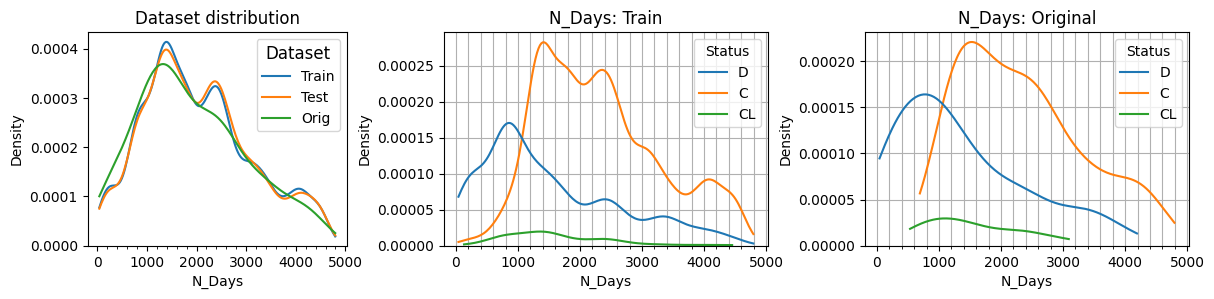

In [28]:
plot_num('N_Days')

In [29]:
train['N_Days_cat'] = (train['N_Days'] < 1000).astype('int8')
train.groupby('N_Days_cat')[TARGET].value_counts(normalize=True)

N_Days_cat  Status
0           C         0.734996
            D         0.233359
            CL        0.031645
1           D         0.783893
            C         0.167785
            CL        0.048322
Name: proportion, dtype: float64

### Age

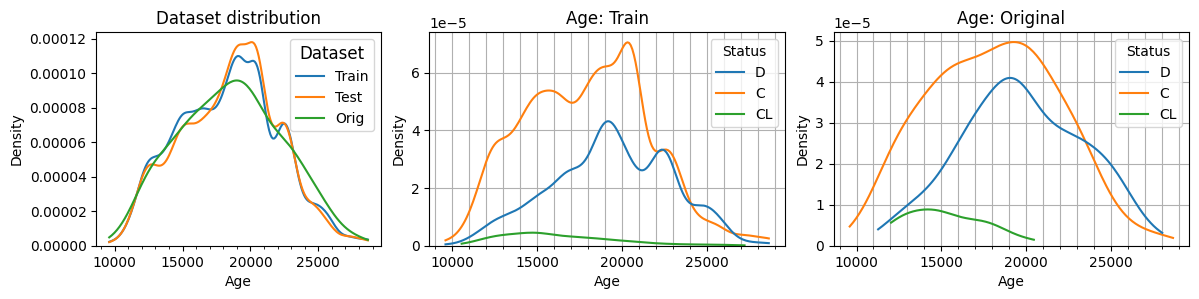

In [30]:
plot_num('Age')

In [31]:
train['Age_cat'] = (train['Age'] > 22000).astype('int8')
train.groupby('Age_cat')[TARGET].value_counts(normalize=True)

Age_cat  Status
0        C         0.660642
         D         0.299470
         CL        0.039888
1        D         0.499664
         C         0.487559
         CL        0.012777
Name: proportion, dtype: float64

### Bilirubin

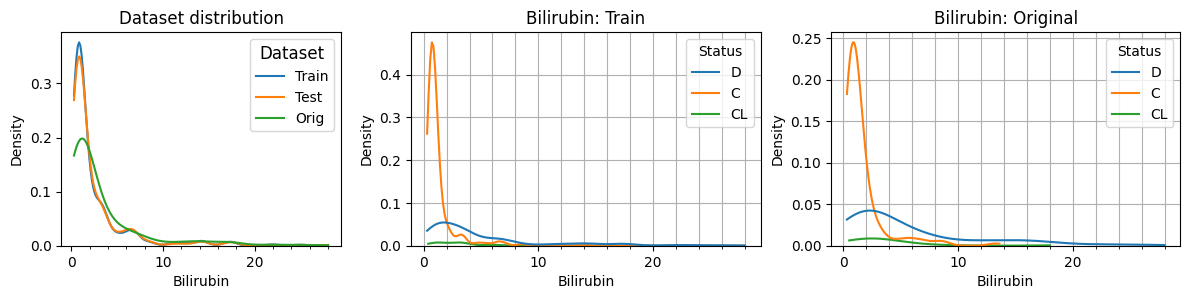

In [32]:
plot_num('Bilirubin')

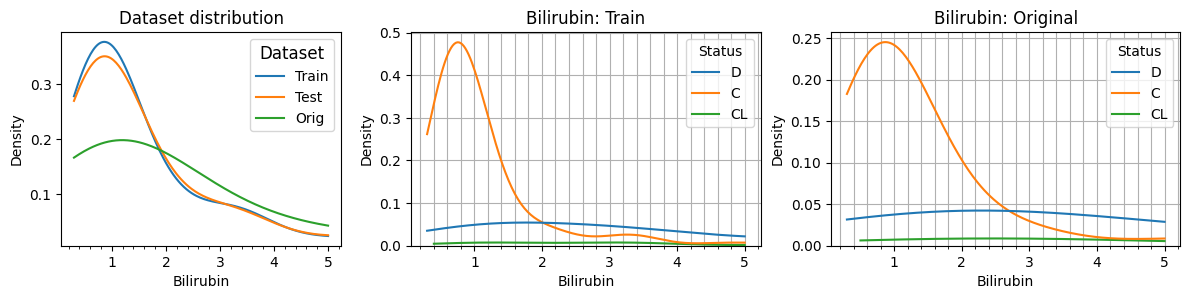

In [33]:
plot_num('Bilirubin', (0, 5))

In [34]:
train['Bilirubin_cat'] = (train['Bilirubin'] > 2).astype('int8')
train.groupby('Bilirubin_cat')[TARGET].value_counts(normalize=True)

Bilirubin_cat  Status
0              C         0.802149
               D         0.177473
               CL        0.020378
1              D         0.680893
               C         0.253291
               CL        0.065816
Name: proportion, dtype: float64

### Cholesterol

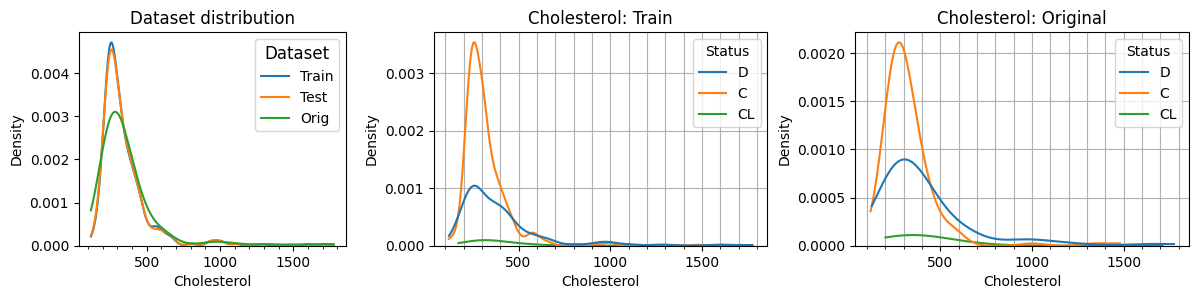

In [35]:
plot_num('Cholesterol')

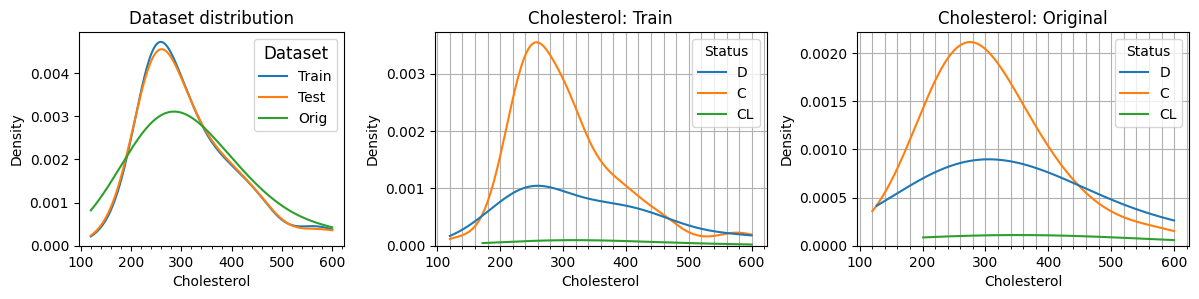

In [36]:
plot_num('Cholesterol', (0, 600))

In [37]:
train['Cholesterol_cat'] = (train['Cholesterol'] > 400).astype('int8')
train.groupby('Cholesterol_cat')[TARGET].value_counts(normalize=True)

Cholesterol_cat  Status
0                C         0.681531
                 D         0.288147
                 CL        0.030323
1                D         0.510932
                 C         0.438435
                 CL        0.050633
Name: proportion, dtype: float64

### Albumin

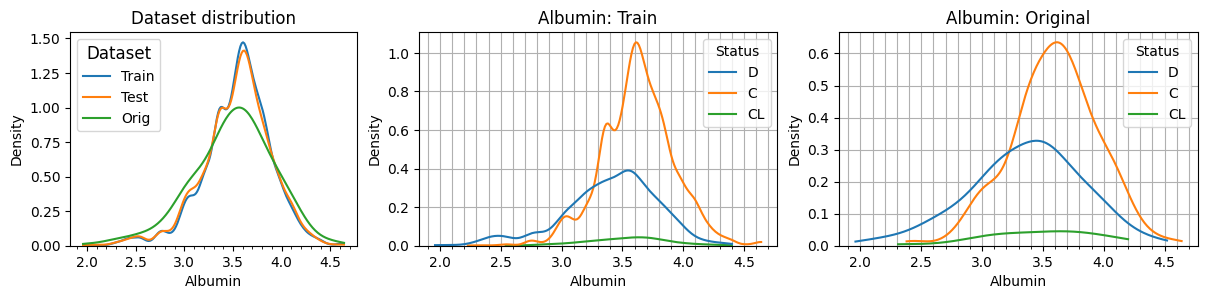

In [38]:
plot_num('Albumin')

In [39]:
train['Albumin_cat'] = (train['Albumin'] < 3.2).astype('int8')
train.groupby('Albumin_cat')[TARGET].value_counts(normalize=True)

Albumin_cat  Status
0            C         0.675570
             D         0.290608
             CL        0.033822
1            D         0.652559
             C         0.306102
             CL        0.041339
Name: proportion, dtype: float64

### Copper

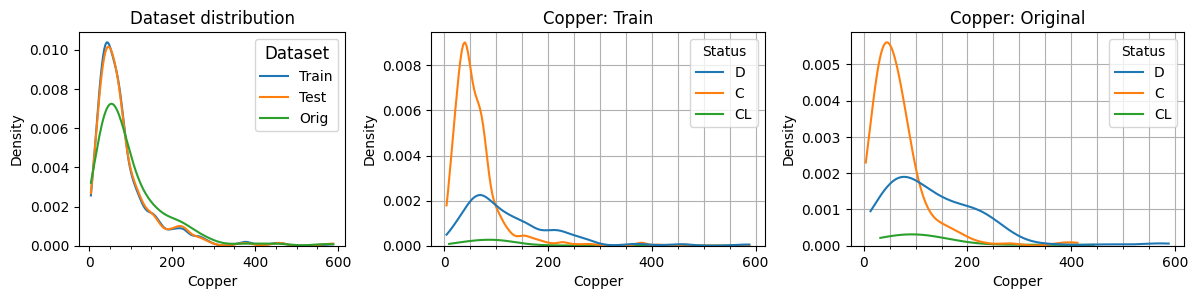

In [40]:
plot_num('Copper')

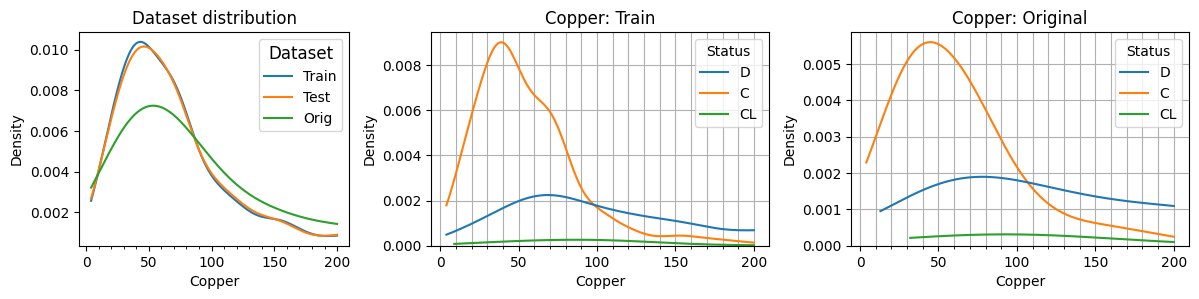

In [41]:
plot_num('Copper', (0, 200))

In [42]:
train['Copper_cat'] = (train['Copper'] > 90).astype('int8')
train.groupby('Copper_cat')[TARGET].value_counts(normalize=True)

Copper_cat  Status
0           C         0.757651
            D         0.216522
            CL        0.025827
1           D         0.639876
            C         0.302842
            CL        0.057282
Name: proportion, dtype: float64

### Alk_Phos

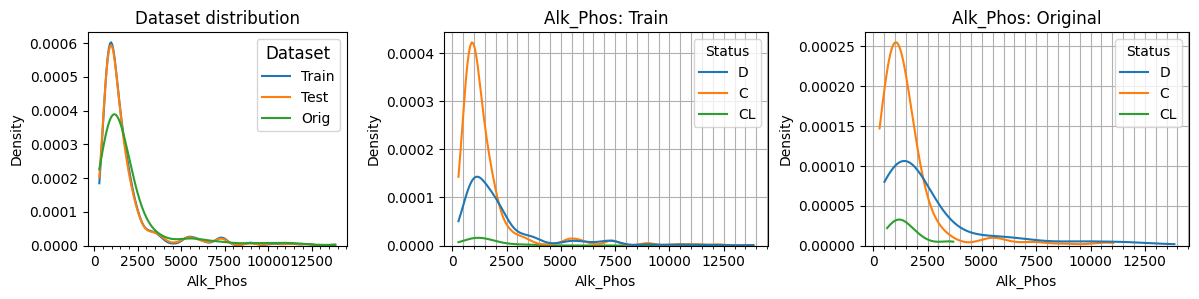

In [43]:
plot_num('Alk_Phos')

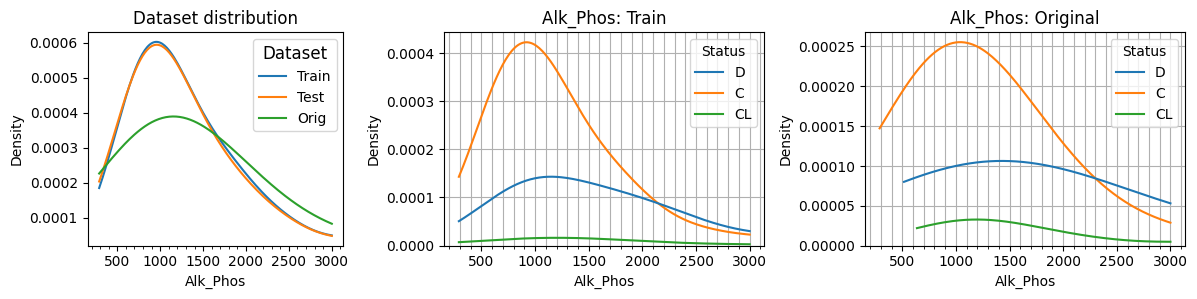

In [44]:
plot_num('Alk_Phos', (0, 3000))

In [45]:
train['Alk_Phos_cat'] = (train['Alk_Phos'] > 2000).astype('int8')
train.groupby('Alk_Phos_cat')[TARGET].value_counts(normalize=True)

Alk_Phos_cat  Status
0             C         0.684125
              D         0.280525
              CL        0.035349
1             D         0.537975
              C         0.429229
              CL        0.032796
Name: proportion, dtype: float64

### SGOT

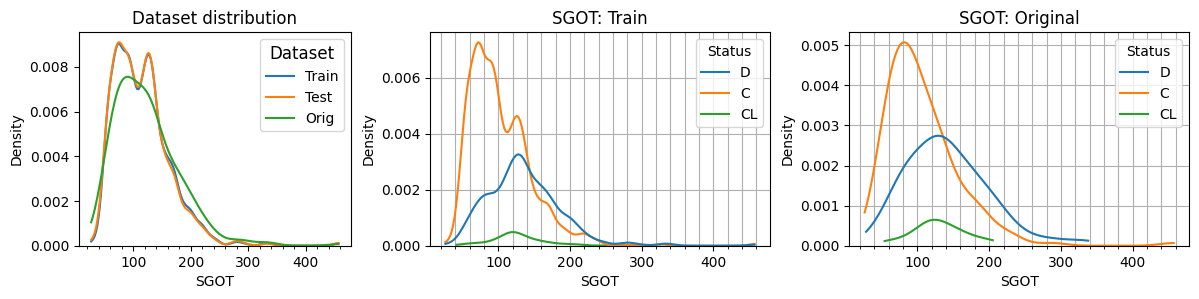

In [46]:
plot_num('SGOT')

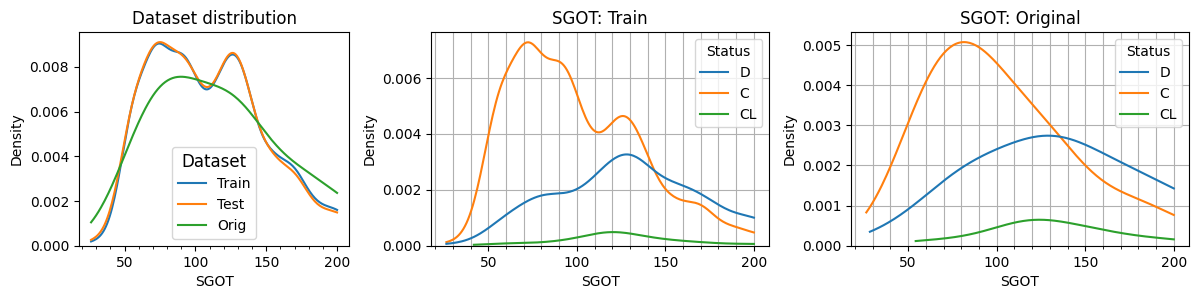

In [47]:
plot_num('SGOT', (0, 200))

In [48]:
train['SGOT_cat'] = (train['SGOT'] > 130).astype('int8')
train.groupby('SGOT_cat')[TARGET].value_counts(normalize=True)

SGOT_cat  Status
0         C         0.725999
          D         0.242436
          CL        0.031565
1         D         0.535868
          C         0.422579
          CL        0.041552
Name: proportion, dtype: float64

### Tryglicerides

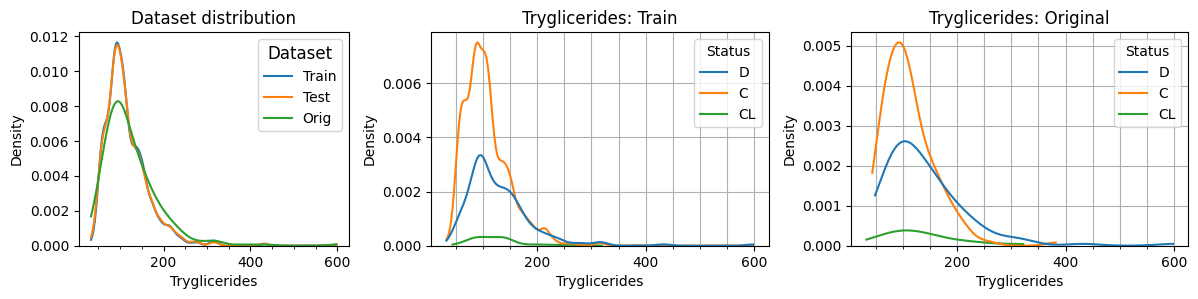

In [49]:
plot_num('Tryglicerides')

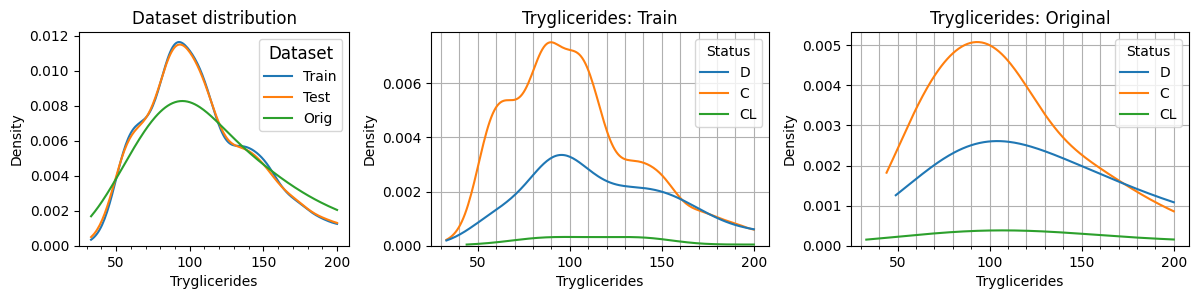

In [50]:
plot_num('Tryglicerides', (0, 200))

In [51]:
train['Tryglicerides_cat'] = (train['Tryglicerides'] > 150).astype('int8')
train.groupby('Tryglicerides_cat')[TARGET].value_counts(normalize=True)

Tryglicerides_cat  Status
0                  C         0.665367
                   D         0.298768
                   CL        0.035865
1                  D         0.502011
                   C         0.467828
                   CL        0.030161
Name: proportion, dtype: float64

### Platelets

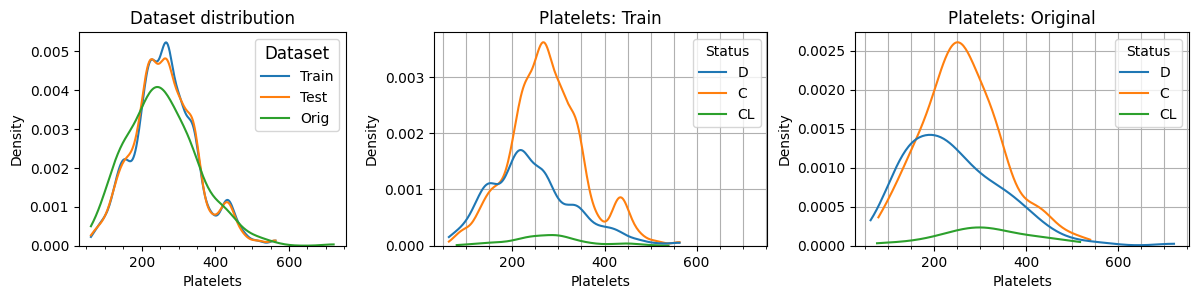

In [52]:
plot_num('Platelets')

In [53]:
train['Platelets_cat'] = (train['Platelets'] < 175).astype('int8')
train.groupby('Platelets_cat')[TARGET].value_counts(normalize=True)

Platelets_cat  Status
0              C         0.663106
               D         0.300697
               CL        0.036196
1              D         0.548110
               C         0.425258
               CL        0.026632
Name: proportion, dtype: float64

### Prothrombin

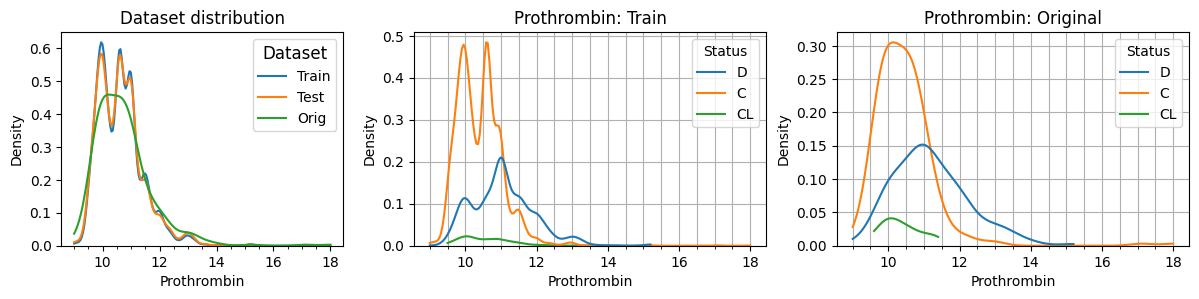

In [54]:
plot_num('Prothrombin')

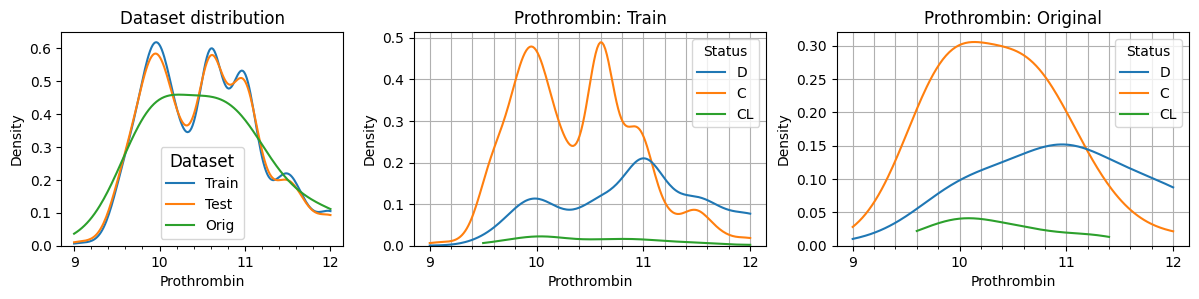

In [55]:
plot_num('Prothrombin', (0, 12))

In [56]:
train['Prothrombin_cat'] = (train['Prothrombin'] > 11).astype('int8')
train.groupby('Prothrombin_cat')[TARGET].value_counts(normalize=True)

Prothrombin_cat  Status
0                C         0.714606
                 D         0.249639
                 CL        0.035754
1                D         0.664269
                 C         0.304556
                 CL        0.031175
Name: proportion, dtype: float64

## Categorical features

In [57]:
for f in cat_features:
    with pd.option_context('display.precision', 3):
        display(train.groupby(f)[TARGET].value_counts(normalize=True, dropna=False))
    print('-' * 30)

Drug             Status
D-penicillamine  C         0.617
                 D         0.344
                 CL        0.039
Placebo          C         0.638
                 D         0.331
                 CL        0.031
Name: proportion, dtype: float64

------------------------------


Sex  Status
F    C         0.645
     D         0.320
     CL        0.034
M    D         0.554
     C         0.404
     CL        0.042
Name: proportion, dtype: float64

------------------------------


Ascites  Status
N        C         0.656
         D         0.308
         CL        0.036
Y        D         0.918
         C         0.066
         CL        0.016
Name: proportion, dtype: float64

------------------------------


Hepatomegaly  Status
N             C         0.822
              D         0.150
              CL        0.028
Y             D         0.516
              C         0.443
              CL        0.041
Name: proportion, dtype: float64

------------------------------


Spiders  Status
N        C         0.716
         D         0.252
         CL        0.032
Y        D         0.600
         C         0.357
         CL        0.042
Name: proportion, dtype: float64

------------------------------


Edema  Status
N      C         0.677
       D         0.287
       CL        0.036
S      D         0.684
       C         0.276
       CL        0.040
Y      D         0.971
       C         0.023
       CL        0.006
Name: proportion, dtype: float64

------------------------------


Stage  Status
1.0    C         0.884
       D         0.098
       CL        0.018
2.0    C         0.783
       D         0.189
       CL        0.028
3.0    C         0.729
       D         0.235
       CL        0.036
4.0    D         0.582
       C         0.378
       CL        0.040
Name: proportion, dtype: float64

------------------------------


In [58]:
cat_features.extend([f for f in train.columns if f.endswith('_cat')])

*Drug* -> no difference in proportion (might be informative in combination with other features)  
*Sex* -> slight difference  
*all other features* (including binary features created from numerical columns) -> significant splits

# Preprocessing

### Creating categorical features for all datasets

In [59]:
def create_cat(df):
    df['N_Days_cat'] = (df['N_Days'] < 1000).astype('int8')
    df['Age_cat'] = (df['Age'] > 22000).astype('int8')
    df['Bilirubin_cat'] = (df['Bilirubin'] > 2).astype('int8')
    df['Cholesterol_cat'] = (df['Cholesterol'] > 400).astype('int8')
    df['Albumin_cat'] = (df['Albumin'] < 3.2).astype('int8')
    df['Copper_cat'] = (df['Copper'] > 90).astype('int8')
    df['Alk_Phos_cat'] = (df['Alk_Phos'] > 2000).astype('int8')
    df['SGOT_cat'] = (df['SGOT'] > 130).astype('int8')
    df['Tryglicerides_cat'] = (df['Tryglicerides'] > 150).astype('int8')
    df['Platelets_cat'] = (df['Platelets'] < 175).astype('int8')
    df['Prothrombin_cat'] = (df['Prothrombin'] > 11).astype('int8')
    return df

In [60]:
# already done for train data in feature exploration
test = create_cat(test.copy())
trial_manual_imp = create_cat(trial_manual_imp.copy())
trial_mf_imp = create_cat(trial_mf_imp.copy())

_ = gc.collect()

### Encoding categorical values

In [61]:
def encode_cat(df):
    df['Drug'] = df['Drug'].replace({'Placebo': 0, 'D-penicillamine': 1}).astype('int8')
    df['Sex'] = df['Sex'].replace({'F': 0, 'M': 1}).astype('int8')
    df['Ascites'] = df['Ascites'].replace({'N': 0, 'Y': 1}).astype('int8')
    df['Hepatomegaly'] = df['Hepatomegaly'].replace({'N': 0, 'Y': 1}).astype('int8')
    df['Spiders'] = df['Spiders'].replace({'N': 0, 'Y': 1}).astype('int8')
    df['Edema'] = df['Edema'].replace({'N': 0, 'S': 1, 'Y': 2}).astype('int8')
    df['Stage'] = df['Stage'].astype('int8')
    return df

In [62]:
train = encode_cat(train.copy())
test = encode_cat(test.copy())
trial_manual_imp = encode_cat(trial_manual_imp.copy())
trial_mf_imp = encode_cat(trial_mf_imp.copy())

_ = gc.collect()

### Encode target column

In [63]:
target_mapping = {'C': 0, 'CL': 1, 'D': 2}

train[TARGET] = train[TARGET].replace(target_mapping)
trial_manual_imp[TARGET] = trial_manual_imp[TARGET].replace(target_mapping)
trial_mf_imp[TARGET] = trial_mf_imp[TARGET].replace(target_mapping)

# Modeling

### Feature-sets

1. Original/Base features

In [64]:
base_features = [
    'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 
    'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 
    'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage'
]

2. Categorical-only features

In [65]:
np.asarray(cat_features)

array(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema',
       'Stage', 'N_Days_cat', 'Age_cat', 'Bilirubin_cat',
       'Cholesterol_cat', 'Albumin_cat', 'Copper_cat', 'Alk_Phos_cat',
       'SGOT_cat', 'Tryglicerides_cat', 'Platelets_cat',
       'Prothrombin_cat'], dtype='<U17')

3. Base + Created features

In [66]:
all_features = test.columns

### Cross-validation framework

In [67]:
def eval_metric(y_true, y_pred):
    return log_loss(y_true, y_pred)

In [68]:
def custom_cv(features, model, extend=None, folds=7, seed=SEED, verbose=True):
    oof_preds = {}
    test_preds = {}
    
    X_test = test[features]
    
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (train_ids, val_ids) in enumerate(cv.split(train, train[TARGET])):
        X_train, X_val = train.iloc[train_ids], train.iloc[val_ids]
        if extend is not None:
            X_train = pd.concat([X_train, extend], axis=0) \
                        .drop_duplicates(keep='last', ignore_index=True)
        
        y_train, y_val = X_train.pop(TARGET), X_val.pop(TARGET)
        X_train, X_val = X_train[features], X_val[features]
        
        model.fit(X_train, y_train)
        
        val_preds = model.predict_proba(X_val)
        oof_preds.update(dict(zip(val_ids, val_preds)))
        test_preds[f'fold{fold}'] = model.predict_proba(X_test)
        
        if verbose:
            score = eval_metric(y_val, val_preds)
            print(f'Fold #{fold}: {score:.4f}', end=' | ')
            
        _ = gc.collect()
    
    test_preds['mean'] = sum(test_preds.values()) / folds  # mean of fold-wise predictions
    oof_preds = pd.DataFrame.from_dict(oof_preds, orient='index').sort_index()
    print(f'OOF score: {eval_metric(train[TARGET], oof_preds):.4f}\n')
    
    return oof_preds, test_preds

### Model

In [69]:
num_preprocessor = make_pipeline(RobustScaler(), MinMaxScaler())
preprocessor = make_column_transformer(
    (num_preprocessor, make_column_selector(dtype_exclude='int8')), # numerical
    (MinMaxScaler(), make_column_selector(dtype_include='int8')), # categorical
    remainder='passthrough',
    n_jobs=-1)

In [70]:
classifier = LogisticRegression(
    C=0.5,
    max_iter=1000,
    penalty='elasticnet',
    l1_ratio=0.75,
    solver='saga',
    multi_class='multinomial',
    n_jobs=-1,
    random_state=SEED)

In [71]:
model = make_pipeline(preprocessor, classifier)

### Submission files

In [72]:
def create_submission_files(test_preds, config, notebook='00'):
    sub = sample_sub.copy()
    sub['Status_C'] = test_preds['mean'][:, 0]
    sub['Status_CL'] = test_preds['mean'][:, 1]
    sub['Status_D'] = test_preds['mean'][:, 2]
    sub.to_csv(f'{notebook}_{config}.csv', index=False)

# Experiments

In [73]:
op = {} # Train-set OOF predictions
tp = {} # Test-set predictions

### Base features fixed, different datasets

In [74]:
%%time

feature_set = 'base'
model_name = 'logreg'
extension = 'noext'
folds = 7
seed = SEED
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(base_features, model)

create_submission_files(tp[config], config)

Fold #0: 0.5344 | Fold #1: 0.5012 | Fold #2: 0.5153 | Fold #3: 0.5458 | Fold #4: 0.5620 | Fold #5: 0.5004 | Fold #6: 0.5206 | OOF score: 0.5257

CPU times: user 2.71 s, sys: 442 ms, total: 3.16 s
Wall time: 3.16 s


In [75]:
%%time

feature_set = 'base'
model_name = 'logreg'
extension = 'manimp'
folds = 7
seed = SEED
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(base_features, model, extend=trial_manual_imp)

create_submission_files(tp[config], config)

Fold #0: 0.5340 | Fold #1: 0.5008 | Fold #2: 0.5154 | Fold #3: 0.5450 | Fold #4: 0.5621 | Fold #5: 0.5001 | Fold #6: 0.5206 | OOF score: 0.5254

CPU times: user 2.85 s, sys: 404 ms, total: 3.25 s
Wall time: 3.25 s


In [76]:
%%time

feature_set = 'base'
model_name = 'logreg'
extension = 'mfimp'
folds = 7
seed = SEED
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(base_features, model, extend=trial_mf_imp)

create_submission_files(tp[config], config)

Fold #0: 0.5340 | Fold #1: 0.5009 | Fold #2: 0.5154 | Fold #3: 0.5450 | Fold #4: 0.5621 | Fold #5: 0.5001 | Fold #6: 0.5205 | OOF score: 0.5254

CPU times: user 2.85 s, sys: 420 ms, total: 3.27 s
Wall time: 3.26 s


### Dataset fixed, different feature sets

In [77]:
%%time

feature_set = 'cat'
model_name = 'logreg'
extension = 'noext'
folds = 7
seed = SEED
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(cat_features, model)

create_submission_files(tp[config], config)

Fold #0: 0.5068 | Fold #1: 0.4831 | Fold #2: 0.4955 | Fold #3: 0.5276 | Fold #4: 0.5390 | Fold #5: 0.4788 | Fold #6: 0.5118 | OOF score: 0.5061

CPU times: user 2.34 s, sys: 423 ms, total: 2.76 s
Wall time: 2.76 s


In [78]:
%%time

feature_set = 'all'
model_name = 'logreg'
extension = 'noext'
folds = 7
seed = SEED
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(all_features, model)

create_submission_files(tp[config], config)

Fold #0: 0.4968 | Fold #1: 0.4654 | Fold #2: 0.4795 | Fold #3: 0.5108 | Fold #4: 0.5297 | Fold #5: 0.4676 | Fold #6: 0.4976 | OOF score: 0.4925

CPU times: user 4.95 s, sys: 384 ms, total: 5.33 s
Wall time: 5.33 s


### Different feature sets, different datasets

In [79]:
%%time

feature_set = 'cat'
model_name = 'logreg'
extension = 'manimp'
folds = 7
seed = SEED
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(cat_features, model, extend=trial_manual_imp)

create_submission_files(tp[config], config)

Fold #0: 0.5060 | Fold #1: 0.4830 | Fold #2: 0.4954 | Fold #3: 0.5270 | Fold #4: 0.5390 | Fold #5: 0.4785 | Fold #6: 0.5117 | OOF score: 0.5058

CPU times: user 2.45 s, sys: 393 ms, total: 2.85 s
Wall time: 2.85 s


In [80]:
%%time

feature_set = 'all'
model_name = 'logreg'
extension = 'mfimp'
folds = 7
seed = SEED
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(all_features, model, extend=trial_mf_imp)

create_submission_files(tp[config], config)

Fold #0: 0.4960 | Fold #1: 0.4648 | Fold #2: 0.4795 | Fold #3: 0.5102 | Fold #4: 0.5296 | Fold #5: 0.4670 | Fold #6: 0.4971 | OOF score: 0.4920

CPU times: user 5.22 s, sys: 411 ms, total: 5.63 s
Wall time: 5.63 s


### Best config: All features + Extended dataset -> different folds

In [81]:
%%time

feature_set = 'all'
model_name = 'logreg'
extension = 'mfimp'
folds = 10
seed = SEED
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(all_features, model, extend=trial_mf_imp, folds=folds)

create_submission_files(tp[config], config)

Fold #0: 0.4814 | Fold #1: 0.4777 | Fold #2: 0.4919 | Fold #3: 0.4831 | Fold #4: 0.5000 | Fold #5: 0.5272 | Fold #6: 0.5203 | Fold #7: 0.4836 | Fold #8: 0.4484 | Fold #9: 0.5053 | OOF score: 0.4919

CPU times: user 8.27 s, sys: 557 ms, total: 8.83 s
Wall time: 8.83 s


In [82]:
%%time

feature_set = 'all'
model_name = 'logreg'
extension = 'mfimp'
folds = 15
seed = SEED
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(all_features, model, extend=trial_mf_imp, folds=folds)

create_submission_files(tp[config], config)

Fold #0: 0.4845 | Fold #1: 0.5029 | Fold #2: 0.4400 | Fold #3: 0.5034 | Fold #4: 0.4839 | Fold #5: 0.4637 | Fold #6: 0.4762 | Fold #7: 0.5265 | Fold #8: 0.5277 | Fold #9: 0.5300 | Fold #10: 0.4969 | Fold #11: 0.4961 | Fold #12: 0.4385 | Fold #13: 0.4914 | Fold #14: 0.5135 | OOF score: 0.4917

CPU times: user 11.6 s, sys: 856 ms, total: 12.4 s
Wall time: 12.4 s


In [83]:
%%time

feature_set = 'all'
model_name = 'logreg'
extension = 'mfimp'
folds = 20
seed = SEED
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(all_features, model, extend=trial_mf_imp, folds=folds)

create_submission_files(tp[config], config)

Fold #0: 0.4861 | Fold #1: 0.4816 | Fold #2: 0.5097 | Fold #3: 0.4403 | Fold #4: 0.5186 | Fold #5: 0.4515 | Fold #6: 0.5108 | Fold #7: 0.4463 | Fold #8: 0.4624 | Fold #9: 0.5276 | Fold #10: 0.5071 | Fold #11: 0.5442 | Fold #12: 0.5701 | Fold #13: 0.4903 | Fold #14: 0.4883 | Fold #15: 0.4831 | Fold #16: 0.4336 | Fold #17: 0.4721 | Fold #18: 0.5031 | Fold #19: 0.5114 | OOF score: 0.4919

CPU times: user 16 s, sys: 1.18 s, total: 17.2 s
Wall time: 17.2 s


### Best config: All features + Extended dataset + 15 folds -> different seeds

In [84]:
%%time

feature_set = 'all'
model_name = 'logreg'
extension = 'mfimp'
folds = 15
seed = 23
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(all_features, model, extend=trial_mf_imp, folds=folds, seed=seed)

create_submission_files(tp[config], config)

Fold #0: 0.4515 | Fold #1: 0.5419 | Fold #2: 0.5088 | Fold #3: 0.4520 | Fold #4: 0.5184 | Fold #5: 0.4388 | Fold #6: 0.4909 | Fold #7: 0.5068 | Fold #8: 0.5250 | Fold #9: 0.4949 | Fold #10: 0.4612 | Fold #11: 0.4883 | Fold #12: 0.5186 | Fold #13: 0.4965 | Fold #14: 0.4830 | OOF score: 0.4918

CPU times: user 11.9 s, sys: 886 ms, total: 12.8 s
Wall time: 12.8 s


In [85]:
%%time

feature_set = 'all'
model_name = 'logreg'
extension = 'mfimp'
folds = 15
seed = 1807
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(all_features, model, extend=trial_mf_imp, folds=folds, seed=seed)

create_submission_files(tp[config], config)

Fold #0: 0.4575 | Fold #1: 0.4852 | Fold #2: 0.5325 | Fold #3: 0.5533 | Fold #4: 0.4691 | Fold #5: 0.4774 | Fold #6: 0.4457 | Fold #7: 0.5245 | Fold #8: 0.4803 | Fold #9: 0.4927 | Fold #10: 0.4752 | Fold #11: 0.4849 | Fold #12: 0.5220 | Fold #13: 0.5239 | Fold #14: 0.4532 | OOF score: 0.4918

CPU times: user 11.9 s, sys: 899 ms, total: 12.8 s
Wall time: 12.8 s


In [86]:
%%time

feature_set = 'all'
model_name = 'logreg'
extension = 'mfimp'
folds = 15
seed = 1502
config = f'{feature_set}_{model_name}_{extension}_f{folds}_s{seed}'

op[config], tp[config] = custom_cv(all_features, model, extend=trial_mf_imp, folds=folds, seed=seed)

create_submission_files(tp[config], config)

Fold #0: 0.4685 | Fold #1: 0.5035 | Fold #2: 0.4794 | Fold #3: 0.5198 | Fold #4: 0.4842 | Fold #5: 0.4837 | Fold #6: 0.5451 | Fold #7: 0.4741 | Fold #8: 0.4979 | Fold #9: 0.4991 | Fold #10: 0.4736 | Fold #11: 0.4654 | Fold #12: 0.4869 | Fold #13: 0.5082 | Fold #14: 0.4868 | OOF score: 0.4918

CPU times: user 12.5 s, sys: 918 ms, total: 13.4 s
Wall time: 13.4 s


Stable!

In [87]:
!head 00_all_logreg_mfimp_f15_s1502.csv

id,Status_C,Status_CL,Status_D
7905,0.7501150371751759,0.013968159654663165,0.2359168031701609
7906,0.8147713358827926,0.040234625420303975,0.14499403869690342
7907,0.081558049196813,0.049190936393964546,0.8692510144092224
7908,0.9344388714986721,0.010660208879871945,0.05490091962145597
7909,0.8682178263614676,0.024953546818170615,0.1068286268203619
7910,0.9704435329787896,0.008966498857723071,0.020589968163487304
7911,0.935008144744891,0.009469292178553527,0.055522563076555315
7912,0.5696113056518117,0.014194862724711014,0.4161938316234773
7913,0.00542661164656154,0.0024787661515978804,0.9920946222018405


**Time to submit!**